In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### imports

In [27]:
print(__doc__)

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [28]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))
                
def clean_documents(docs):
    def clean_doc(doc):
        ''' remove unwanter characters line new line '''

        unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
        for unwanted_chr in unwanted_chrs:
            doc = doc.replace(unwanted_chr, ' ')

        return doc.strip()
    
    return [clean_doc(doc) for doc in docs]

### load dataset

In [29]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [30]:
# the actual labels as np array
old_labels = np.array(old_labels)
labels = np.zeros(old_labels.shape, dtype=int)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[old_labels == label] = label_classes.index(cl.split('.')[0])

In [31]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 1000 docs and 7 classes: ['sci', 'soc', 'comp', 'alt', 'rec', 'misc', 'talk']


### clean dataset

In [32]:
# clean out the new line characters from text in docs
clean_docs = clean_documents(docs)
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [33]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

# create dataset
word_count = pd.DataFrame(count_vectorizer.vocabulary_, index=[0])

print("word_count shape is", word_count.shape)

word_count shape is (1, 19476)


In [34]:
word_count.head()

,morgan,and,guzman,will,have,era,run,higher,than,last,...,optilink,molested,w4wg,lastdrive,refund,lurch,conical,cornea,skysweepers,skies
0,12098,2746,8904,19022,9063,7336,15421,9215,17511,10791,...,12940,12042,18740,10792,14779,11250,5281,5505,16267,16249


### Prepare Datatset

In [35]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(clean_docs).toarray()

document_word_frequency = pd.DataFrame(doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_binary_frequency = (document_word_frequency > 0).astype('int')

document_word_frequency["__labels__"] = labels
document_word_binary_frequency["__labels__"] = labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (1000, 19477)


In [36]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


In [37]:
document_word_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [38]:
document_word_binary_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


### Cherry pick dataset

In [39]:
# trim the data to words that spread round the corpus

#reduce freq in doc to bin value of 1 or 0
word_doc_binary_freqency = document_word_binary_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

### Topic and word corelation

In [68]:
topic = 0

word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
trust_factor = sigmoid(word_doc_frequency)

word_topic_co = (word_topic_frequency * trust_factor) / word_doc_frequency
word_topic_co.shape

(19476,)

In [69]:
word_topic_co[word_topic_co > 0].sort_values()

windows       0.016393
advance       0.031250
started       0.032258
matter        0.032258
games         0.035714
                ...   
orbit         0.999089
lunar         0.999665
escrow        0.999877
clipper       1.000000
encryption    1.000000
Length: 6758, dtype: float64

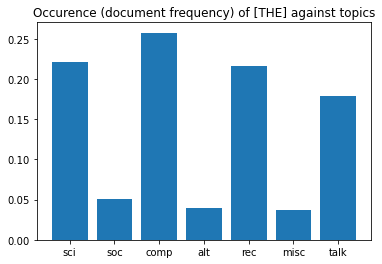

In [85]:
word = "the"
data = document_word_binary_frequency[document_word_binary_frequency[word] > 0]["__labels__"]

values = Counter(data)
values = {label_class:values[topic]/len(data) for topic, label_class in enumerate(label_classes)}

plt.title(f"Occurence (document frequency) of [{word.upper()}] against topics")
plt.bar(values.keys(), values.values())
plt.show()

In [67]:
values

{'sci': 0.0,
 'soc': 0.0,
 'comp': 0.0,
 'alt': 0.0,
 'rec': 0.0,
 'misc': 0.0,
 'talk': 0.0}

In [43]:
document_word_frequency[document_word_binary_frequency[word] > 0][[word, "__labels__"]]

,clipper,__labels__
23,1,0
58,2,0
220,3,0
255,1,0
315,1,0
412,1,0
511,1,0
603,2,0
652,4,0
813,3,0


### Word and word corelation

In [53]:
w1 = "computer"

word_word_frequency = word_doc_binary_freqency[word_doc_binary_freqency[w1] > 0].sum(0)
trust_factor = sigmoid(word_doc_frequency)

word_word_co = (word_word_frequency * trust_factor) / word_doc_frequency
word_word_co.shape

(19476,)

In [59]:
word_word_co[word_word_co > 0.5].sort_values()

boot           0.595984
competition    0.635049
search         0.635049
610            0.635049
uu             0.635049
                 ...   
repairs        0.880797
copyrighted    0.880797
computing      0.880797
seeds          0.880797
computer       1.000000
Length: 945, dtype: float64

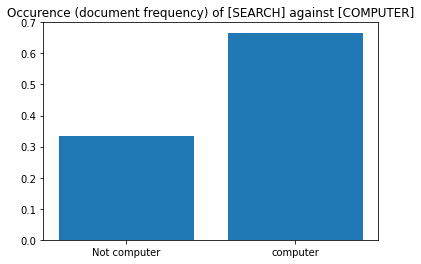

In [83]:
word = "search"

data = document_word_binary_frequency[document_word_binary_frequency[word] > 0][w1]
values = Counter(data)

values = {w:values[index]/len(data) for index, w in enumerate([f"Not {w1}", w1])}

plt.title(f"Occurence (document frequency) of [{word.upper()}] against [{w1.upper()}]")
plt.bar(values.keys(), values.values())
plt.show()